# Deep Pool-based Active Learning: Scikit-activeml with Skorch

> **_Google Colab Note:_** If the notebook fails to run after installing the needed packages, try to restart the runtime (Ctrl + M) under Runtime -> Restart session.

[![Open in Colab](https://colab.research.google.com/assets/colab-badge.svg)](<colab_link>)

**Notebook Dependencies**

Uncomment the following cell to install all dependencies for this tutorial.

In [1]:
# !pip install scikit-activeml skorch torch torchvision torchaudio tqdm pandas

<hr style="border-style: solid; border-top: 1px solid; border-right: 0; border-bottom: 0; border-left: 0;">

In this brief tutorial, we show an example use-case of our package `skactiveml` with the Python package [skorch](https://skorch.readthedocs.io/en/stable/), which is a scikit-learn wrapper for Pytorch models. This way, we are able to implement and test deep learning models in combination with query strategies implemented in our framework.

In [2]:
import matplotlib as mlp
import matplotlib.pyplot as plt
import numpy as np
import torch
import warnings

from copy import deepcopy
from skactiveml.classifier import SklearnClassifier
from skactiveml.pool import UncertaintySampling, QueryByCommittee, RandomSampling, BatchBALD, DiscriminativeAL
from skactiveml.utils import call_func, unlabeled_indices
from sklearn.datasets import fetch_openml
from sklearn.ensemble import VotingClassifier
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from skorch import NeuralNetClassifier
from torch import nn
import torch.nn.functional as F
from torchvision.transforms import transforms
from tqdm import tqdm

mlp.rcParams["figure.facecolor"] = "white"

MISSING_LABEL = -1
RANDOM_STATE = 0
FONTSIZE = 12

np.random.seed(RANDOM_STATE)
torch.manual_seed(RANDOM_STATE)
torch.cuda.manual_seed(RANDOM_STATE)
device = 'cuda' if torch.cuda.is_available() else 'cpu'

warnings.filterwarnings("ignore")

## Loading Digit Data Set
For simplicity, we use the `sklearn` function `fetch_openml` to load the MNIST dataset. The dataset contains 28 x 28px images of handwritten digits from 0 to 9 and the task is to recognize the digits in the images.

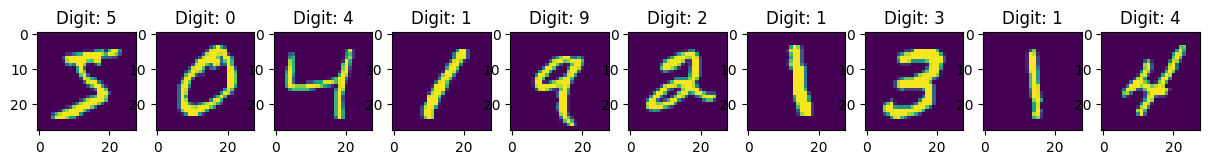

In [3]:
# Load digit data set.
X, y_true = fetch_openml("mnist_784", version=1, return_X_y=True, as_frame=False)

# Visualize first 10 images.
fig, axes = plt.subplots(figsize=(15, 5), nrows=1, ncols=10)
for i in range(10):
    axes[i].set_title(f'Digit: {y_true[i]}', fontsize=FONTSIZE)
    axes[i].imshow(X[i].reshape(28,28))
plt.show()

# Standardize data.
X = StandardScaler().fit_transform(X)

# Reshape samples to n_samples x n_channels x width x height to fit skorch
# requirements.
X = X.reshape((len(X), 1, 28, 28))

# Set data types according to skorch requirements.
X, y_true = X.astype(np.float32), y_true.astype(np.int64)

# Identify list of possible classes.
classes = np.unique(y_true)

# Make a 66-34 train-test split.
X_train, X_test, y_train, y_test = train_test_split(
    X, y_true, train_size=0.66, random_state=RANDOM_STATE
)

## Data Augmentation
Data augmentation is used to artificially generate data from existing data points. In case of image data, this can be done by rotating or scaling the image. Other basic transformations are:
* padding,
* vertical and horizontal flipping,
* translation,
* cropping,
* darkening, brightening, color modification,
* grayscaling,
* changing contrast,
* adding noise,
* random erasing.

For more information on data augmentation take a look at the [Data Augmentation Tutorial](https://www.tensorflow.org/tutorials/images/data_augmentation) of [TensorFlow](https://www.tensorflow.org) or visit [Transforming And Augmenting Images](https://pytorch.org/vision/stable/transforms.html) on [PyTorch](pytorch.org).

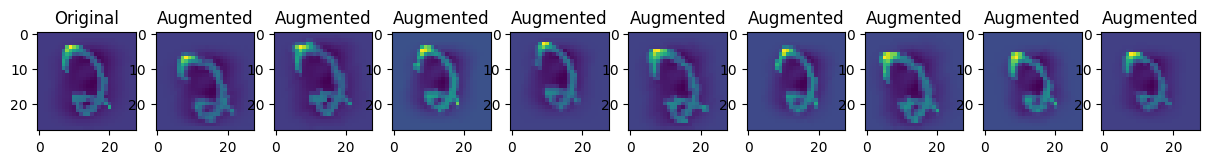

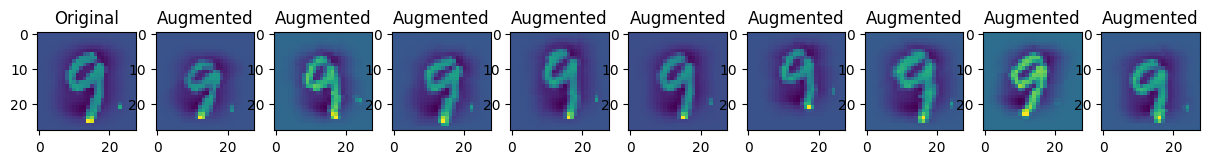

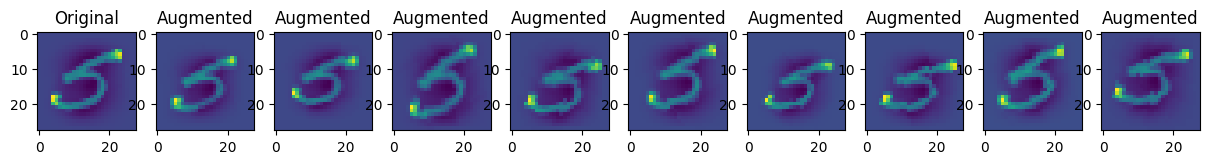

In [4]:
transform = transforms.Compose(
    [
        transforms.RandomAffine(degrees=(-10, 10), translate=(0.05, 0.05), scale=(0.9, 1.1)),
        transforms.RandomPerspective(distortion_scale=0.2, p=1.0),
        transforms.GaussianBlur(kernel_size=(3, 3), sigma=(0.01, 0.1)),
    ]
)


# Visualize 30 augmented images.
for i in range(3):
    X_aug = transform(torch.from_numpy(X_train[:10]))
    fig, axes = plt.subplots(figsize=(15, 5), nrows=1, ncols=10)
    for j in range(10):
        if j==0:
            axes[j].set_title(f'Original', fontsize=FONTSIZE)
            axes[j].imshow(X_train[i].reshape(28,28))
        else:
            axes[j].set_title(f'Augmented', fontsize=FONTSIZE)
            axes[j].imshow(transform(torch.from_numpy(X_train[i])).reshape(28,28))
    plt.show()

## Convolutional Neural Network Ensemble
In the next step, we define a convolutional neural network (CNN) ensemble consisting of ten base CNNs with different initializations.

In [5]:
# Define base module.
class ClassifierModule(nn.Module):
    def __init__(self, n_classes, dropout=0.5, transform=None):
        super(ClassifierModule, self).__init__()
        self.conv1 = nn.Conv2d(1, 32, kernel_size=3)
        self.conv2 = nn.Conv2d(32, 64, kernel_size=3)
        self.conv2_drop = nn.Dropout2d(p=dropout)
        self.fc1 = nn.Linear(1600, 100) # 1600 = number channels * width * height
        self.fc2 = nn.Linear(100, n_classes)
        self.fc1_drop = nn.Dropout(p=dropout)
        self.transform = transform or transforms.Compose([])

    def forward(self, x):
        if self.training:
            # Usually, transforms are part of the datasets.
            with torch.no_grad():
                x = self.transform(x)
        x = torch.relu(F.max_pool2d(self.conv1(x), 2))
        x = torch.relu(F.max_pool2d(self.conv2_drop(self.conv2(x)), 2))

        # flatten over channel, height and width = 1600
        x = x.view(x.size(0), -1)

        x = torch.relu(self.fc1_drop(self.fc1(x)))
        x = torch.softmax(self.fc2(x), dim=-1)
        return x

# Create list of ten base CNNs.
estimators = []
for i in range(5):
    net = NeuralNetClassifier(
        ClassifierModule,
        module__n_classes=10,
        max_epochs=100,
        batch_size=128,
        lr=0.01,
        verbose=False,
        optimizer=torch.optim.SGD,
        optimizer__momentum=0.9,
        optimizer__weight_decay=3e-3,
        train_split=False,
        device=device,
    )
    net.initialize()
    clf = SklearnClassifier(
        estimator=net,
        missing_label=MISSING_LABEL,
        random_state=i,
        classes=classes,
    )
    estimators.append((f'clf {i}', clf))

# Creat voting ensemble out of given ensemble list.
ensemble_init = SklearnClassifier(
    estimator=VotingClassifier(estimators=estimators, voting='soft'),
    missing_label=MISSING_LABEL,
    random_state=RANDOM_STATE,
    classes=classes,
)

## Active Classification
For our ensemble, we evaluate four different query strategies, i.e., random sampling, uncertainty sampling, query-by-committee, and batch BALD, regarding their sample selection. For this purpose, we start with ten labels and make 30 iterations of an active learning cycle with a batch size of 32.

In [6]:
# Define setup.
n_cycles = 30
batch_size = 32
n_sub_set = 1000
qs_dict = {
    'random sampling': RandomSampling(random_state=RANDOM_STATE, missing_label=MISSING_LABEL),
    'uncertainty sampling': UncertaintySampling(random_state=RANDOM_STATE, missing_label=MISSING_LABEL),
    'query-by-committee': QueryByCommittee(random_state=RANDOM_STATE, missing_label=MISSING_LABEL),
    'batch-bald': BatchBALD(random_state=RANDOM_STATE, missing_label=MISSING_LABEL),
}
acc_dict = {key: np.zeros(n_cycles + 1) for key in qs_dict}

# Perform active learning with each query strategy.
for qs_name, qs in qs_dict.items():
    torch.manual_seed(RANDOM_STATE)
    torch.cuda.manual_seed(RANDOM_STATE)

    print(f'Execute active learning using {qs_name}.')

    # Copy initial ensemble model.
    ensemble = deepcopy(ensemble_init)

    # Create array of missing labels as initial labels.
    y = np.full_like(y_train, fill_value=MISSING_LABEL, dtype=np.int64)
    X = X_train

    # Label one sample from each class for warm start.
    for i in range(10):
        y[np.argwhere(y_train==i)[0]] = i

    # Execute active learning cycle.
    for c in tqdm(range(n_cycles)):
        # Fit and evaluate ensemble.
        acc = ensemble.fit(X, y).score(X_test, y_test)
        acc_dict[qs_name][c] = acc

        ulbd_indices = np.random.choice(unlabeled_indices(y, MISSING_LABEL), n_sub_set)

        # Select and update training data.
        query_idx = call_func(
            qs.query,
            X=X[ulbd_indices],
            y=y[ulbd_indices],
            clf=ensemble,
            fit_clf=False,
            ensemble=ensemble,
            fit_ensemble=False,
            batch_size=batch_size,
        )
        query_idx = ulbd_indices[query_idx]
        y[query_idx] = y_train[query_idx]

    # Fit and evaluate ensemble.
    ensemble.fit(X, y)
    acc_dict[qs_name][n_cycles] = ensemble.score(X_test, y_test)

Execute active learning using random sampling.


100%|██████████| 30/30 [04:05<00:00,  8.18s/it]


Execute active learning using uncertainty sampling.


100%|██████████| 30/30 [04:08<00:00,  8.28s/it]


Execute active learning using query-by-committee.


100%|██████████| 30/30 [04:09<00:00,  8.32s/it]


Execute active learning using batch BALD.


100%|██████████| 30/30 [04:05<00:00,  8.19s/it]


## Visualize Results
In the following, we plot the obtained learning curves including the area under learning curve (AULC) scores per query strategy.

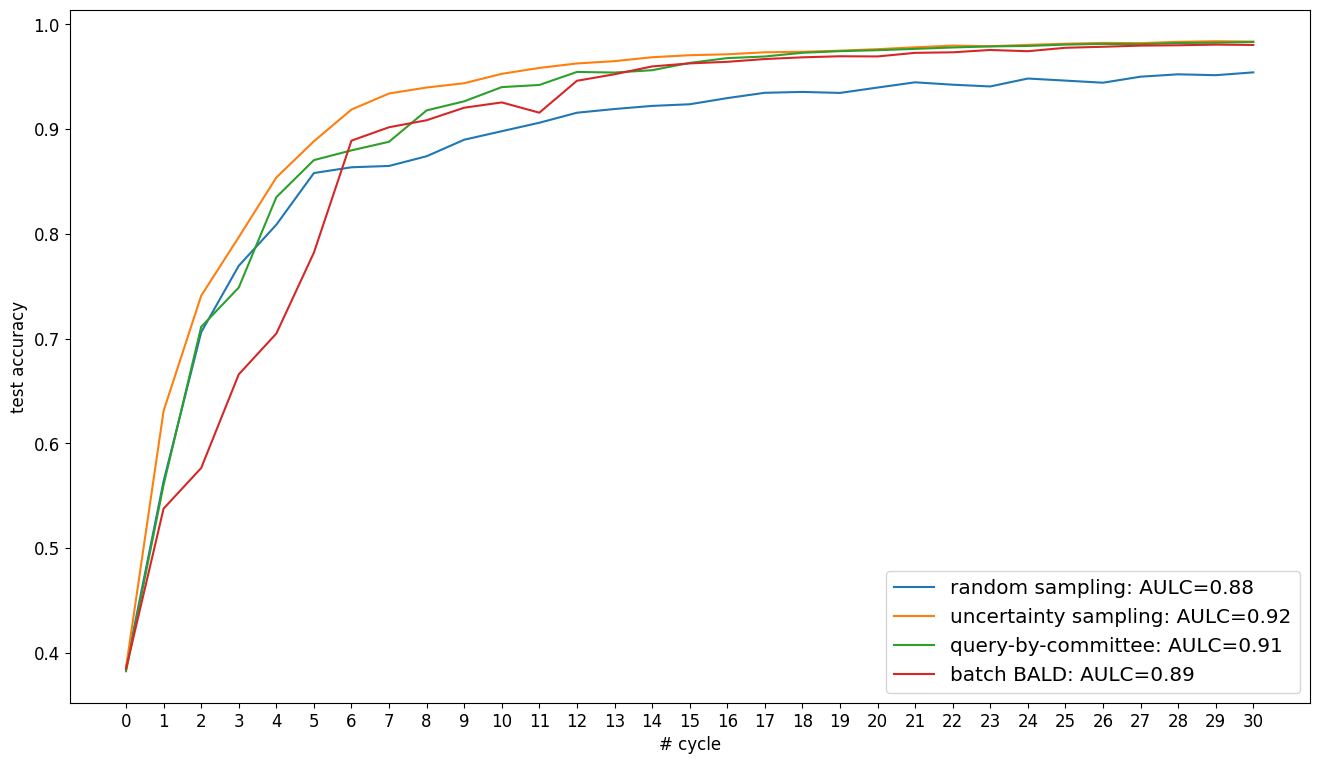

In [7]:
cycles = np.arange(n_cycles + 1, dtype=int)
plt.figure(figsize=(16, 9))
for qs_name, acc in acc_dict.items():
    plt.plot(cycles, acc, label=f'{qs_name}: AULC={round(acc.mean(), 2)}')
plt.xticks(cycles, fontsize=FONTSIZE)
plt.yticks(fontsize=FONTSIZE)
plt.xlabel('# cycle', fontsize=FONTSIZE)
plt.ylabel('test accuracy', fontsize=FONTSIZE)
plt.legend(loc='lower right', fontsize='x-large')
plt.show()